<a href="https://colab.research.google.com/github/RuCoRaMi/thelastdance/blob/main/AD_New_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Libraries

In [78]:
import os
import numpy as np
import pandas as pd
import random
import shutil

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

# 2. Load the Data

In [2]:
#download data
!gdown --id 178zu9MQ_BM-a3xv10DCdmtAh9cV2IHZX -O MRI_images.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=178zu9MQ_BM-a3xv10DCdmtAh9cV2IHZX
From (redirected): https://drive.google.com/uc?id=178zu9MQ_BM-a3xv10DCdmtAh9cV2IHZX&confirm=t&uuid=b6f2d609-3cda-4dec-8e90-e6d67e67a30b
To: /content/MRI_images.zip
100% 396M/396M [00:10<00:00, 36.0MB/s]


In [3]:
#extracting compressed data
!unzip -q "/content/MRI_images.zip" -d "MRI"

In [4]:
#defining dataset variable and showing list of classes
dataset = "/content/MRI/data gabung/data"
folders = os.listdir(dataset)
folders

['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

In [5]:
#defining variables for each class
ND_dir = "/content/MRI/data gabung/data/NonDemented"
VMD_dir = "/content/MRI/data gabung/data/VeryMildDemented"
MD_dir = "/content/MRI/data gabung/data/MildDemented"
GMD_dir = "/content/MRI/data gabung/data/ModerateDemented"

# 3. Exploratory Data Analysis (EDA)

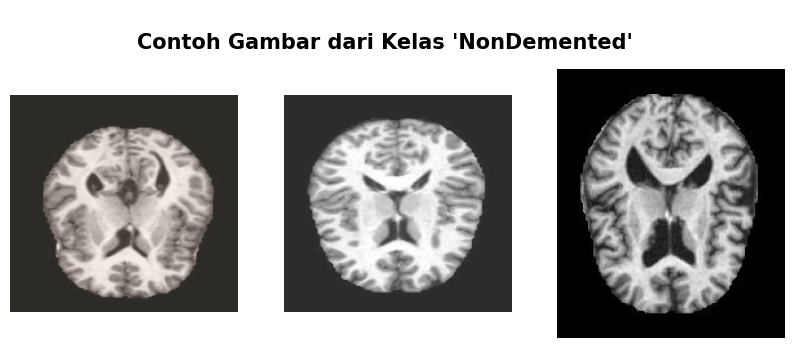

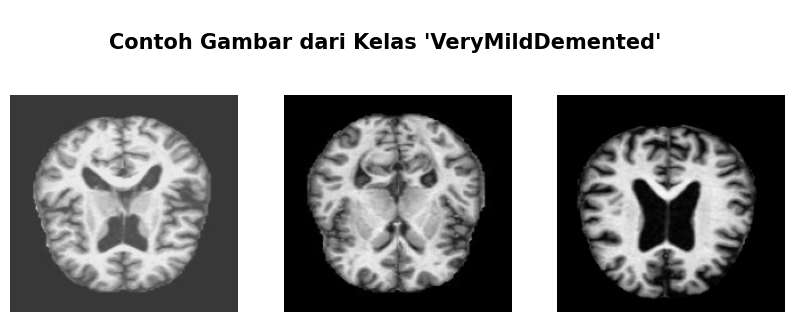

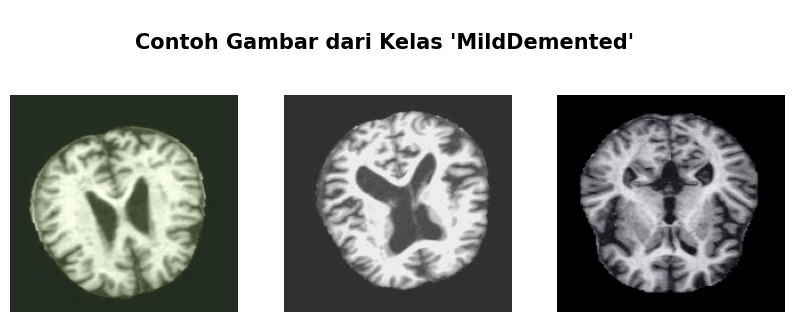

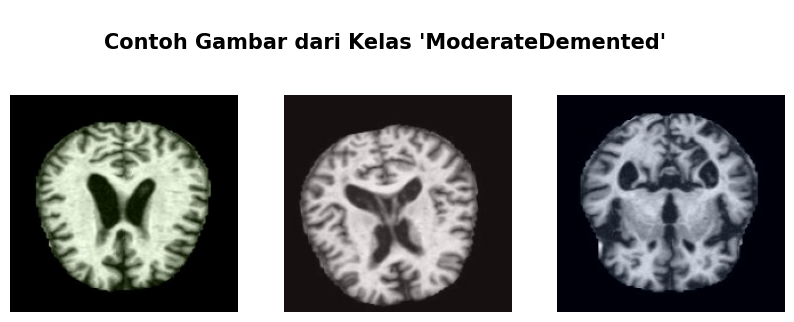

In [6]:
#Demonstrating Example Images
for folder in folders:
  folderpath = os.path.join(dataset, folder)
  images = os.listdir(folderpath)
  images_to_display = [os.path.join(folderpath, img) for img in images[:3]]
  class_name = os.path.basename(folder)

  plt.figure(figsize=(10, 4))
  plt.suptitle(f"\nContoh Gambar dari Kelas '{class_name}'", fontsize=15, fontweight='bold')

  for i, image_path in enumerate(images_to_display):
    plt.subplot(1, 3, i+1)
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [7]:
#Calculating the Number of Images in Each Category
total_data = 0
for folder in folders:
  folder_dir = os.path.join(dataset, folder)
  jumlah_data = len(os.listdir(folder_dir))
  print(f'Jumlah gambar dari folder {folder} = {jumlah_data}')
  total_data += jumlah_data

print(f'\nTotal jumlah gambar = {total_data}')

Jumlah gambar dari folder NonDemented = 12800
Jumlah gambar dari folder VeryMildDemented = 11200
Jumlah gambar dari folder MildDemented = 9856
Jumlah gambar dari folder ModerateDemented = 6528

Total jumlah gambar = 40384


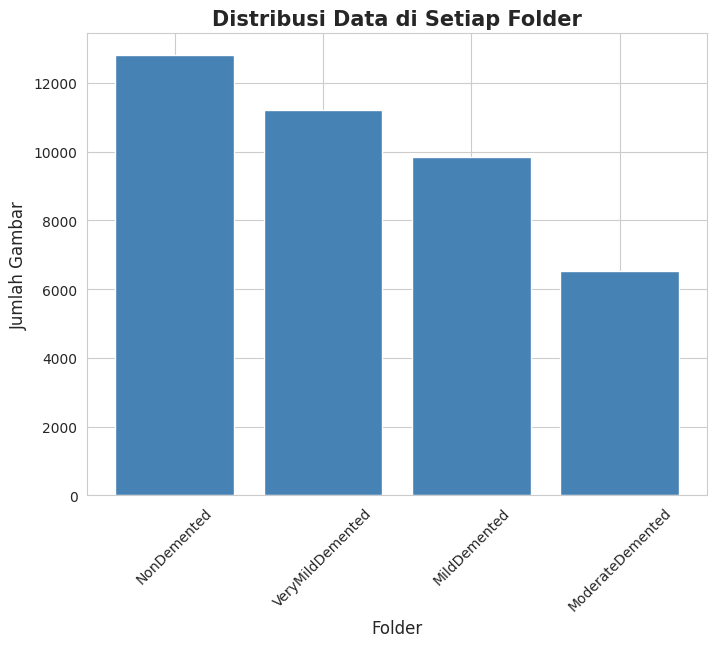

In [8]:
#Visualizing Data Distribution
folder_count = {}
for folder in folders:
  folder_path = os.path.join(dataset, folder)
  if os.path.isdir(folder_path):
    folder_count[folder] = len(os.listdir(folder_path))

plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
plt.bar(folder_count.keys(), folder_count.values(), color='#4682B4')
plt.xlabel('Folder', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.title('Distribusi Data di Setiap Folder', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

In [9]:
#Checking Format of the Images
def get_file_format(filename):
  return filename.split('.')[-1]

format_count = {}

for folder in folders:
  folder_path = os.path.join(dataset, folder)
  if os.path.isdir(folder_path):
    format_count[folder] = {}
    for file in os.listdir(folder_path):
      if os.path.isfile(os.path.join(folder_path, file)):
        file_format = get_file_format(file)
        if file_format in format_count[folder]:
          format_count[folder][file_format] += 1
        else:
          format_count[folder][file_format] = 1

for folder, counts in format_count.items():
  print(f'\nFolder: {folder}')
  for file_format, count in counts.items():
    print(f"Format: {file_format}, Jumlah: {count}")
  print()


Folder: NonDemented
Format: jpg, Jumlah: 12800


Folder: VeryMildDemented
Format: jpg, Jumlah: 11200


Folder: MildDemented
Format: jpg, Jumlah: 9856


Folder: ModerateDemented
Format: jpg, Jumlah: 6528



# 4. Data Pre-Processing

Normalizing Data Distribution (Undersampling Method)

In [10]:
num_images_per_folder = []
folder_names = []

#setting max number of data to keep for each class
max_images_per_class = 6500

total_images = 0

#iterate through every folder, listing every images on them
for folder in folders:
  folder_path = os.path.join(dataset, folder)
  if os.path.isdir(folder_path):
    images = os.listdir(folder_path)
    num_images = 0
    images_to_keep = []

    for image in images:
      images_to_keep.append(image)
      num_images += 1

    #checking if number of data exceed the maximum value set earlier, randomly keeping images
    if folder not in ['ModerateDemented'] or num_images > max_images_per_class:
      images_to_keep = random.sample(images_to_keep, max_images_per_class)

    #removing images that not selected
    for image in images:
      if image not in images_to_keep:
        os.remove(os.path.join(folder_path, image))

    num_images = len(images_to_keep)
    total_images += num_images
    num_images_per_folder.append(num_images)
    folder_names.append(folder)

    print(f'Jumlah gambar dari folder {folder} = {num_images}')
    print('-'*40)

print(f'\nTotal jumlah gambar = {total_images}')


Jumlah gambar dari folder NonDemented = 6500
----------------------------------------
Jumlah gambar dari folder VeryMildDemented = 6500
----------------------------------------
Jumlah gambar dari folder MildDemented = 6500
----------------------------------------
Jumlah gambar dari folder ModerateDemented = 6500
----------------------------------------

Total jumlah gambar = 26000


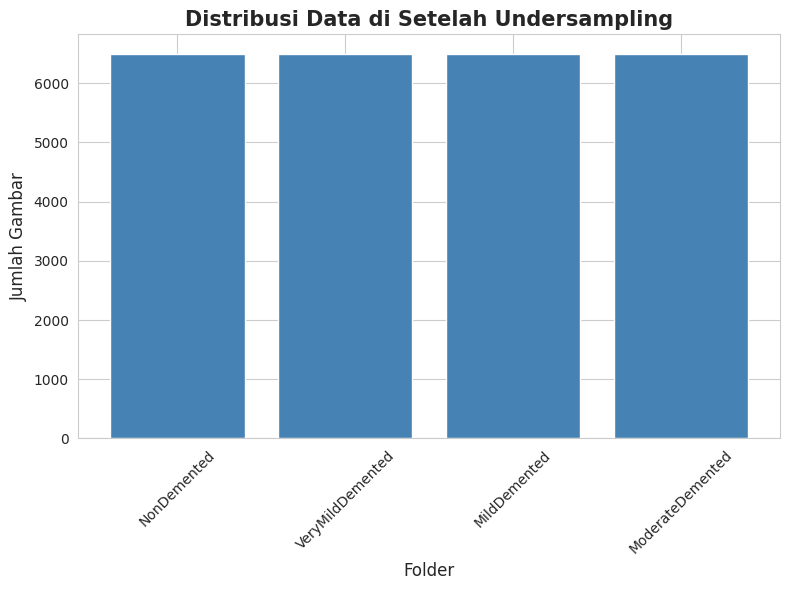

In [11]:
plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
plt.bar(folder_names, num_images_per_folder, color='#4682B4')
plt.xlabel('Folder', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.title('Distribusi Data di Setelah Undersampling', fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Splitting the Data

In [12]:
#classes directories
directories = [ND_dir, VMD_dir, MD_dir, GMD_dir]

#listing files from all classes
file_lists = [[os.path.join(d,f) for f in os.listdir(d)] for d in directories]

In [13]:
#setting ratio for training and validation data
train_ratio = 0.85
val_ratio = 0.1

#initiating list to store directories for each data
train_files = []
val_files = []
test_files = []

#iterating through every file in file_lists
for files in file_lists:
  random.shuffle(files)
  num_train = int(len(files) * train_ratio)
  num_val = int(len(files) * val_ratio)

  train_files.append(files[:num_train])
  val_files.append(files[num_train:num_train+num_val])
  test_files.append(files[num_train+num_val:])

print(f'Jumlah data training: {sum([len(files) for files in train_files])}')
print(f'Jumlah data validasi: {sum([len(files) for files in val_files])}')
print(f'Jumlah data uji: {sum([len(files) for files in test_files])}')

Jumlah data training: 22100
Jumlah data validasi: 2600
Jumlah data uji: 1300


In [14]:
#Creating dictionary to store number of images on each class in each subset
distribution = {'pelatihan' : {}, 'validasi' : {}, 'uji' : {}}

#calculating distribution of each class in each subset
for subset, files_list in zip(['pelatihan', 'validasi', 'uji'], [train_files, val_files, test_files]):
  for files in files_list:
    for file in files:
      folder_name = file.split('/')[-2]
      if folder_name not in distribution[subset]:
        distribution[subset][folder_name] = 1
      else:
        distribution[subset][folder_name] += 1

#display data distribution of each class in each subset
for subset, distribution in distribution.items():
  print(f'Distribusi kelas pada subset Data {subset.capitalize()}')
  for class_name, count in distribution.items():
    print(f'> {class_name}: {count} gambar')
  print('-'*40,'\n')

Distribusi kelas pada subset Data Pelatihan
> NonDemented: 5525 gambar
> VeryMildDemented: 5525 gambar
> MildDemented: 5525 gambar
> ModerateDemented: 5525 gambar
---------------------------------------- 

Distribusi kelas pada subset Data Validasi
> NonDemented: 650 gambar
> VeryMildDemented: 650 gambar
> MildDemented: 650 gambar
> ModerateDemented: 650 gambar
---------------------------------------- 

Distribusi kelas pada subset Data Uji
> NonDemented: 325 gambar
> VeryMildDemented: 325 gambar
> MildDemented: 325 gambar
> ModerateDemented: 325 gambar
---------------------------------------- 



In [15]:
#creating final directories
os.mkdir('/content/Data Final')
os.mkdir('/content/Data Final/train')
os.mkdir('/content/Data Final/val')
os.mkdir('/content/Data Final/test')

#assigning directories to dataset
train_dir = '/content/Data Final/train'
val_dir = '/content/Data Final/val'
test_dir = '/content/Data Final/test'

#moving divided dataset to corresponding directories
for files in train_files:
  label = os.path.basename(os.path.dirname(files[0]))
  label_dir = os.path.join(train_dir, label)
  os.makedirs(label_dir, exist_ok=True)
  for file in files:
    shutil.copy2(file, label_dir)

for files in val_files:
  label = os.path.basename(os.path.dirname(files[0]))
  label_dir = os.path.join(val_dir, label)
  os.makedirs(label_dir, exist_ok=True)
  for file in files:
    shutil.copy2(file, label_dir)

for files in test_files:
  label = os.path.basename(os.path.dirname(files[0]))
  label_dir = os.path.join(test_dir, label)
  os.makedirs(label_dir, exist_ok=True)
  for file in files:
    shutil.copy2(file, label_dir)

In [16]:
#creating dataframe
def make_df(ts_path):
  classes = []
  class_path = []
  files = os.listdir(ts_path)
  for file in files:
    label_dir = os.path.join(ts_path, file)
    label = os.listdir(label_dir)
    for image in label:
      image_path = os.path.join(label_dir, image)
      class_path.append(image_path)
      classes.append(file)
  image_classes = pd.Series(classes, name='Class')
  image_path = pd.Series(class_path, name='Class Path')
  make_df = pd.concat([image_path, image_classes], axis=1)
  return make_df

In [17]:
#Creating training dataframe
train_df = make_df(train_dir)
train_df.head()

,Class Path,Class
0,/content/Data Final/train/NonDemented/nonDem14...,NonDemented
1,/content/Data Final/train/NonDemented/a6927135...,NonDemented
2,/content/Data Final/train/NonDemented/nonDem68...,NonDemented
3,/content/Data Final/train/NonDemented/a70ca0aa...,NonDemented
4,/content/Data Final/train/NonDemented/811332f0...,NonDemented


In [18]:
#Creating validation dataframe
val_df = make_df(val_dir)
val_df.head()

,Class Path,Class
0,/content/Data Final/val/NonDemented/nonDem1472...,NonDemented
1,/content/Data Final/val/NonDemented/17f719ca-7...,NonDemented
2,/content/Data Final/val/NonDemented/6166f9b6-1...,NonDemented
3,/content/Data Final/val/NonDemented/a14c37de-f...,NonDemented
4,/content/Data Final/val/NonDemented/nonDem172.jpg,NonDemented


In [19]:
#Creating test dataframe
test_df = make_df(test_dir)
test_df.head()

,Class Path,Class
0,/content/Data Final/test/NonDemented/a6473b34-...,NonDemented
1,/content/Data Final/test/NonDemented/79375025-...,NonDemented
2,/content/Data Final/test/NonDemented/3117eeae-...,NonDemented
3,/content/Data Final/test/NonDemented/0c0a8b63-...,NonDemented
4,/content/Data Final/test/NonDemented/a556e202-...,NonDemented


# 6. Data Pre-Processing (ImageDataGenerator)

In [44]:
#declaring batch size and input image size
BATCH_SIZE = 64
SEED = 10
IMG_SIZE = (224, 224)

#declaring datagen object
datagen = ImageDataGenerator(rescale=1./255)

#Creating training set generator
train_generator = datagen.flow_from_dataframe(train_df,
                                              x_col='Class Path',
                                              y_col='Class',
                                              batch_size=BATCH_SIZE,
                                              seed=SEED,
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=IMG_SIZE)

#Creating validation set generator
val_generator = datagen.flow_from_dataframe(val_df,
                                            x_col='Class Path',
                                            y_col='Class',
                                            batch_size=BATCH_SIZE,
                                            seed=SEED,
                                            shuffle=True,
                                            class_mode='categorical',
                                            target_size=IMG_SIZE)

#Creating test set generator
test_generator = datagen.flow_from_dataframe(test_df,
                                             x_col='Class Path',
                                             y_col='Class',
                                             batch_size=BATCH_SIZE,
                                             seed=SEED,
                                             shuffle=True,
                                             class_mode='categorical',
                                             target_size=IMG_SIZE)

Found 22100 validated image filenames belonging to 4 classes.
Found 2600 validated image filenames belonging to 4 classes.
Found 1300 validated image filenames belonging to 4 classes.


In [45]:
classes = list(train_generator.class_indices.keys())
classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [79]:
#defining input shape
IMG_SHAPE = (224, 224, 3)

opt = Adamax(learning_rate=0.001)
#Building Model
def create_model():

    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top = False,
        input_shape = IMG_SHAPE,
        pooling='max'
    )

    for layers in resnet_model.layers[:100]:
        layers.trainable = False #freeze first number of layers of resnet
    for layers in resnet_model.layers[100:]:
        layers.trainable = True #unfreeze layers start from indexed number

    x = resnet_model.output
    #x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, kernel_regularizer=regularizers.l2(0.001),
              activity_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001),
              activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # output layer
    predictions = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return res_model

In [80]:
res_model = create_model()

In [81]:
res_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 61,028,996 (232.81 MB)

 Trainable params: 59,087,748 (225.40 MB)

 Non-trainable params: 1,941,248 (7.41 MB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.173442 to fit



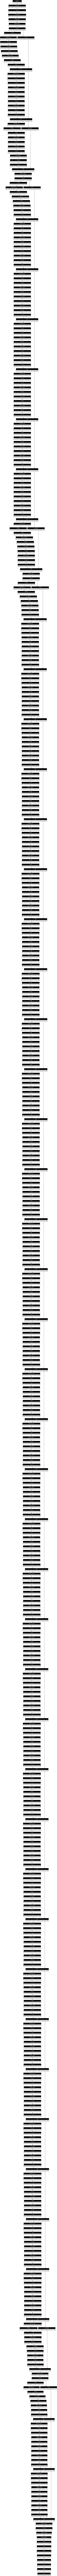

In [82]:
# visualize model architecture
tf.keras.utils.plot_model(res_model, show_shapes=True)

In [83]:
# early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# training model
history = res_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 596s 1s/step - accuracy: 0.2599 - loss: 7.7843 - val_accuracy: 0.2500 - val_loss: 2.5984
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.2454 - loss: 2.5702 - val_accuracy: 0.2500 - val_loss: 3.0713
Epoch 3/50
205/346 ━━━━━━━━━━━━━━━━━━━━ 2:23 1s/step - accuracy: 0.2553 - loss: 2.4172

KeyboardInterrupt: 

# 7. Evaluation

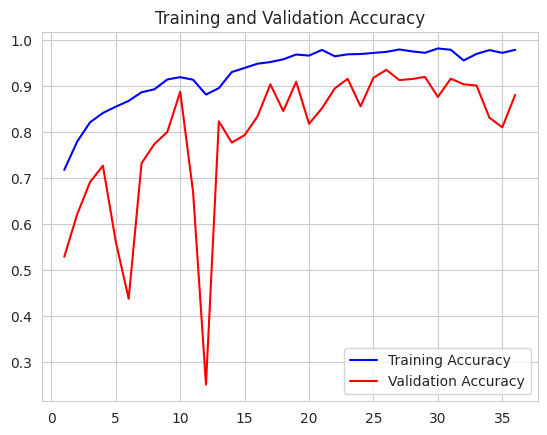

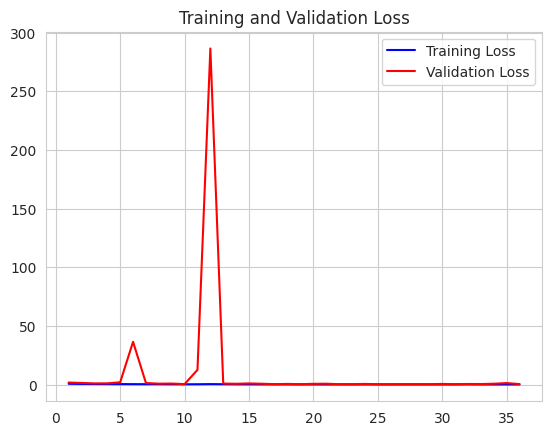

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

#Plotting training and validation accuracy graph
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#Plotting training and validation loss graph
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:

print(f'\nTraining accuracy: {acc*100:.2f} %')
print(f'Validation accuracy: {val_acc*100:.2f} %')
print('-'*30)
print(f'\nTraining loss: {loss:.2f}')
print(f'Validation loss: {val_loss:.2f}')

In [ ]:
#Test data confusion matrix
def create_classification_report(model_name):
  y_pred = model_name.predict(test_generator)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = test_generator.classes

  cm = confusion_matrix(y_true, y_pred)
  class_names = list(test_generator.class_indices.keys())

  plt.figure(figsize=(8, 6), dpi=100)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  #plt.savefig('confusion_matrix.png')
  plt.show()

  report = classification_report(y_true, y_pred, target_names=class_names)
  print(report)

In [ ]:
create_classification_report(res_model)